# <center>Telecom Churn : Prediction</center> 

## Problem Statement<br>
Analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.<br>
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. The telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.
## Goal
- Analyse customer data with **Prepaid** pland in **India and Southest Asia**
- Identify High-Value customer based on there uses
    - Take first 2 month average recharge amount
    - Identify customer with more than **70<sup>th</sup> Percentile** average recharge amount 
- Here we have 4 month data (Jun, July, August, September)
    - Tag churner in the last month (September) using fourth month data
    - Based on usage of fourth month such as incoming and outgoing call and internet use
    - After prediction remove all the attributes corresponding to the churn phase


## Load Libraries

In [551]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

In [478]:
pd.set_option('display.max.columns', 250)
warnings.filterwarnings('ignore')

## Load Data

In [479]:
custDf = pd.read_csv("telecom_churn_data.csv")

In [480]:
custDf.shape

(99999, 226)

In [481]:
custDf.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

## Data Cleaning and Manipulation

In [482]:
#chnaging few coluumn names
custDf.rename(columns={'jun_vbc_3g':'vbc_3g_6', 'jul_vbc_3g':'vbc_3g_7', 'aug_vbc_3g':'vbc_3g_8', 'sep_vbc_3g':'vbc_3g_9'}, inplace=True)

Indentify **High-Value** customer

In [483]:
#Check for different recharge amount and recharge count
custDf[[c for c in custDf.columns if ((c.endswith('_6')) 
                                      & (('rch' in c) | 
                                         ('rech' in c) | 
                                         ('sachet' in c) | 
                                         ('monthly' in c) | 
                                         ('night' in c) | 
                                         ('VBC' in c)))]].tail(5)

,total_rech_num_6,total_rech_amt_6,max_rech_amt_6,date_of_last_rech_6,last_day_rch_amt_6,date_of_last_rech_data_6,total_rech_data_6,max_rech_data_6,count_rech_2g_6,count_rech_3g_6,av_rech_amt_data_6,night_pck_user_6,monthly_2g_6,sachet_2g_6,monthly_3g_6,sachet_3g_6
99994,2,60,60,6/3/2014,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
99995,5,110,110,6/17/2014,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
99996,5,119,50,6/13/2014,30,6/13/2014,2.0,25.0,2.0,0.0,39.0,0.0,0,2,0,0
99997,3,381,202,6/17/2014,202,6/17/2014,3.0,202.0,1.0,2.0,583.0,0.0,0,1,1,1
99998,5,710,175,6/16/2014,175,6/11/2014,1.0,154.0,1.0,0.0,154.0,0.0,1,0,0,0


In [484]:
custDf[['total_rech_num_6','total_rech_data_6', 'count_rech_2g_6', 'count_rech_3g_6', 'sachet_2g_6', 'sachet_3g_6','monthly_2g_6','sachet_2g_6','monthly_3g_6']][~np.isnan(custDf['total_rech_data_6'])].head()

,total_rech_num_6,total_rech_data_6,count_rech_2g_6,count_rech_3g_6,sachet_2g_6,sachet_3g_6,monthly_2g_6,sachet_2g_6,monthly_3g_6
0,4,1.0,0.0,1.0,0,0,0,0,1
4,5,1.0,1.0,0.0,1,0,0,1,0
19,2,1.0,1.0,0.0,0,0,1,0,0
32,6,3.0,3.0,0.0,3,0,0,3,0
33,7,5.0,0.0,5.0,0,1,0,0,4


In [485]:
custDf[['total_rech_amt_6','max_rech_amt_6', 'max_rech_data_6', 'av_rech_amt_data_6']][~np.isnan(custDf['total_rech_data_6'])].head()

,total_rech_amt_6,max_rech_amt_6,max_rech_data_6,av_rech_amt_data_6
0,362,252,252.0,252.0
4,196,56,56.0,56.0
19,154,154,154.0,154.0
32,69,25,25.0,64.0
33,1058,252,252.0,1057.0


In [486]:
print("Missinf value : Average Recharge Amount for data (June) : ", custDf[np.isnan(custDf['av_rech_amt_data_6']) & custDf['total_rech_data_6'] > 0].size)
print("Missinf value : Average Recharge Amount for data (July) : ", custDf[np.isnan(custDf['av_rech_amt_data_7']) & custDf['total_rech_data_7'] > 0].size)
print("Missinf value : Average Recharge Amount for data (August) : ", custDf[np.isnan(custDf['av_rech_amt_data_8']) & custDf['total_rech_data_8'] > 0].size)

Missinf value : Average Recharge Amount for data (June) :  0
Missinf value : Average Recharge Amount for data (July) :  0
Missinf value : Average Recharge Amount for data (August) :  0


In [487]:
#Calculate Total recharge amount spned on data for specific month
custDf['total_rech_amt_data_6'] = custDf['av_rech_amt_data_6'] * custDf['total_rech_data_6']
custDf['total_rech_amt_data_7'] = custDf['av_rech_amt_data_7'] * custDf['total_rech_data_7']
custDf['total_rech_amt_data_8'] = custDf['av_rech_amt_data_8'] * custDf['total_rech_data_8']

In [586]:
custDf['total_rech_6'] = custDf[['total_rech_amt_data_6', 'total_rech_amt_6']].sum(axis=1)
custDf['total_rech_7'] = custDf[['total_rech_amt_data_7', 'total_rech_amt_7']].sum(axis=1)
custDf['total_rech_8'] = custDf[['total_rech_amt_data_8', 'total_rech_amt_8']].sum(axis=1)
custDf['av_rech_6_7'] = custDf[['total_rech_6','total_rech_7']].mean(axis=1)

In [489]:
#70th percentile of two month average recharge  
rechAmt = custDf['av_rech_6_7'].quantile(0.7)
rechAmt

478.0

In [694]:
#High value customer with average recharge amount greater than 70 percentile
hvCust = custDf[custDf['av_rech_6_7'] >= rechAmt]

In [695]:
hvCust.shape

(30001, 233)

In [696]:
#Will drop 'av_rech_6_7' columns which might create confusion in EDA process
hvCust.drop(labels=['av_rech_6_7'], axis=1, inplace=True)

Tag churner based on Incomeing & Outgoing call as well as Internet usages in september month.

In [697]:
hvCust['churn'] = hvCust.apply(lambda x : 1 if ((x['total_ic_mou_9'] == 0) & (x['total_og_mou_9'] == 0) & (x['vol_2g_mb_9'] == 0) & (x['vol_3g_mb_9'] == 0)) else 0, axis=1)

In [698]:
hvCust[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9', 'churn']].head(10)

,total_ic_mou_9,total_og_mou_9,vol_2g_mb_9,vol_3g_mb_9,churn
0,0.00,0.00,0.00,0.00,1
7,0.00,0.00,0.00,0.00,1
8,34.91,142.18,0.00,0.00,0
21,252.61,1031.53,0.00,0.00,0
23,127.48,127.63,13.93,314.74,0
33,114.16,1.70,30.92,5588.11,0
38,114.09,708.04,0.00,0.00,0
41,165.84,89.13,0.00,0.00,0
48,894.81,2319.01,0.00,0.00,0
53,680.61,503.06,0.82,0.00,0


In [699]:
#Drop attribute from churn phase
colsToDel = [c for c in hvCust.columns if "_9" in c]
hvCust.drop(labels=colsToDel, inplace=True, axis=1)
hvCust.shape

(30001, 178)

In [700]:
# as name suggeted "Last Date of Month" column contain unique value (Last day of that month)
#So we can drop these 3 columns
hvCust.drop(labels=['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8'], inplace=True, axis=1)

In [701]:
hvCust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Columns: 175 entries, mobile_number to churn
dtypes: float64(141), int64(28), object(6)
memory usage: 40.3+ MB


In [709]:
missingDf = pd.DataFrame(data=hvCust.isnull().sum() / hvCust.index.size * 100, columns=['MissingPercent'])
missingDf =  missingDf[missingDf['MissingPercent'] > 0]
missingDf.reset_index(inplace=True)
missingDf.columns = ['Feature', 'MissingPercent']
missingDf[['Month', 'Feature']] = missingDf['Feature'].apply(lambda x : pd.Series([6, x.replace('_6', '')] if x.endswith('_6') else ([7, x.replace('_7', '')] if x.endswith('_7') else ([8, x.replace('_8', '')] if x.endswith('_8') else [None, x]))))

In [710]:
pvtDf =  missingDf[~np.isnan(missingDf['MissingPercent'])].pivot_table(index=['Feature'], columns=['Month'])
pvtDf['MissingPercent'].sort_values(by=[6.0, 'Feature'], ascending=False)

Month,6.0,7.0,8.0
Feature,,,
date_of_last_rech_data,44.148528,43.145228,46.825106
std_og_t2t_mou,1.816606,1.789940,3.913203
std_og_t2m_mou,1.816606,1.789940,3.913203
std_og_t2f_mou,1.816606,1.789940,3.913203
std_og_t2c_mou,1.816606,1.789940,3.913203
std_og_mou,1.816606,1.789940,3.913203
std_ic_t2t_mou,1.816606,1.789940,3.913203
std_ic_t2o_mou,1.816606,1.789940,3.913203
std_ic_t2m_mou,1.816606,1.789940,3.913203


In [704]:
#hvCust[hvCust['total_rech_amt_6'] == 0][[c for c in hvCust.columns if '_6' in c]]
hvCust[np.isnan(hvCust['total_rech_data_6']) | 
      np.isnan(hvCust['total_rech_amt_data_6']) |
      np.isnan(hvCust['night_pck_user_6']) |
      np.isnan(hvCust['max_rech_data_6']) |
      np.isnan(hvCust['fb_user_6']) |
      np.isnan(hvCust['count_rech_3g_6']) |
      np.isnan(hvCust['count_rech_2g_6']) |
      np.isnan(hvCust['av_rech_amt_data_6']) |
      np.isnan(hvCust['arpu_3g_6']) |
      np.isnan(hvCust['arpu_2g_6'])][[c for c in hvCust.columns if '_6' in c]].head(10)

,arpu_6,onnet_mou_6,offnet_mou_6,roam_ic_mou_6,roam_og_mou_6,loc_og_t2t_mou_6,loc_og_t2m_mou_6,loc_og_t2f_mou_6,loc_og_t2c_mou_6,loc_og_mou_6,std_og_t2t_mou_6,std_og_t2m_mou_6,std_og_t2f_mou_6,std_og_t2c_mou_6,std_og_mou_6,isd_og_mou_6,spl_og_mou_6,og_others_6,total_og_mou_6,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,loc_ic_t2f_mou_6,loc_ic_mou_6,std_ic_t2t_mou_6,std_ic_t2m_mou_6,std_ic_t2f_mou_6,std_ic_t2o_mou_6,std_ic_mou_6,total_ic_mou_6,spl_ic_mou_6,isd_ic_mou_6,ic_others_6,total_rech_num_6,total_rech_amt_6,max_rech_amt_6,date_of_last_rech_6,last_day_rch_amt_6,date_of_last_rech_data_6,total_rech_data_6,max_rech_data_6,count_rech_2g_6,count_rech_3g_6,av_rech_amt_data_6,vol_2g_mb_6,vol_3g_mb_6,arpu_3g_6,arpu_2g_6,night_pck_user_6,monthly_2g_6,sachet_2g_6,monthly_3g_6,sachet_3g_6,fb_user_6,vbc_3g_6,total_rech_amt_data_6,total_rech_6
7,1069.180,57.84,453.43,16.23,23.74,51.39,308.63,62.13,0.00,422.16,4.30,49.89,6.66,0.0,60.86,0.00,4.50,0.00,487.53,58.14,217.56,152.16,427.88,36.89,91.44,52.19,0.0,180.54,626.46,0.21,2.06,15.74,5,1580,1580,6/27/2014,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,18.74,NaN,1580.0
8,378.721,413.69,94.66,0.00,0.00,297.13,80.96,0.00,0.00,378.09,116.56,13.69,0.00,0.0,130.26,0.00,0.00,0.00,508.36,23.84,57.58,0.00,81.43,0.00,22.43,0.00,0.0,22.43,103.86,0.00,0.00,0.00,19,437,90,6/25/2014,50,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,122.16,NaN,437.0
21,514.453,102.41,757.93,0.00,0.00,4.48,91.81,0.75,0.00,97.04,97.93,665.36,0.00,0.0,763.29,0.00,0.00,0.00,860.34,2.48,118.23,4.61,125.33,14.06,67.69,0.00,0.0,81.76,207.09,0.00,0.00,0.00,22,600,50,6/30/2014,30,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,0.00,NaN,600.0
23,74.350,48.96,85.41,0.00,0.00,48.96,82.94,0.00,0.00,131.91,0.00,2.36,0.00,0.0,2.36,0.00,0.10,0.00,134.38,20.71,95.91,0.00,116.63,0.51,2.43,0.00,0.0,2.94,119.58,0.00,0.00,0.00,3,0,0,6/18/2014,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,0.00,NaN,0.0
38,363.987,248.99,88.86,0.00,0.00,29.88,33.76,0.00,0.00,63.64,219.11,55.09,0.00,0.0,274.21,0.00,0.00,0.00,337.86,8.68,37.99,0.00,46.68,4.54,19.56,0.00,0.0,24.11,70.79,0.00,0.00,0.00,27,420,30,6/30/2014,20,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,0.00,NaN,420.0
41,482.832,86.39,232.36,0.00,0.00,86.39,142.69,54.14,0.00,283.24,0.00,0.00,34.68,0.0,34.68,0.79,0.03,0.00,318.76,59.54,12.18,11.70,83.43,0.00,0.00,0.00,0.0,0.00,278.31,0.00,194.31,0.56,4,496,150,6/24/2014,150,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,0.00,NaN,496.0
48,1873.271,2061.69,1087.76,0.00,0.00,611.18,1012.04,19.34,0.06,1642.58,1450.51,56.29,0.00,0.0,1506.81,0.00,1.58,1.45,3152.43,361.94,842.49,7.94,1212.39,19.24,18.91,0.00,0.0,38.16,1250.56,0.00,0.00,0.00,13,2317,250,6/29/2014,250,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,0.00,NaN,2317.0
69,809.518,181.63,1608.76,0.00,0.00,12.48,35.76,0.00,0.00,48.24,169.14,1572.99,0.00,0.0,1742.14,0.00,0.00,0.00,1790.39,212.03,40.88,2.76,255.68,0.00,0.18,0.00,0.0,0.18,255.86,0.00,0.00,0.00,16,986,110,6/30/2014,110,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,0.00,NaN,986.0
73,2401.829,2020.84,3897.06,0.00,0.00,78.76,255.29,0.10,0.00,334.16,1942.08,3640.44,0.00,0.0,5582.53,0.00,1.21,11.90,5929.81,53.81,171.01,2.00,226.83,9.04,26.69,0.00,0.0,35.74,262.58,0.00,0.00,0.00,33,2759,150,6/30/2014,110,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,0.00,NaN,2759.0
77,30.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,4,0,0,6/17/2014,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,0.00,NaN,0.0


Apart from **date_of_last_rech** column all other column have some common pattern.<BR>
All feature variable related to Internet Service have **44% missing data in Jun, 43 in July and 47 in August ** month.<BR>
Same as internet service, calling service related features also have common trend.<BR>

This trend shows there are few customers only use calling service and not using any internet service, hence approx. 44% missing data for all columns of internet service related feature.<BR>
We can impute zero in such columns except last recharge date data column.

In [711]:
hvCust.drop(labels=['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8'], axis=1, inplace=True)

In [715]:
cols = pvtDf[pvtDf['MissingPercent'][6] > 40].index
cols = [c + "_" + month for c in cols for month in ['6','7','8']]
cols.remove('date_of_last_rech_data_6')
cols.remove('date_of_last_rech_data_7')
cols.remove('date_of_last_rech_data_8')

In [716]:
#cols = ['total_rech_data_6','total_rech_amt_data_6','night_pck_user_6','max_rech_data_6','fb_user_6','count_rech_3g_6','count_rech_2g_6','av_rech_amt_data_6','arpu_3g_6','arpu_2g_6']
hvCust[cols] = hvCust[cols].fillna(value=0)

In [717]:
#Drop rows of other missing data
hvCust.dropna(axis=0, inplace=True)

In [718]:
missingDf = pd.DataFrame(data=hvCust.isnull().sum() / hvCust.index.size * 100, columns=['MissingPercent'])
missingDf =  missingDf[missingDf['MissingPercent'] > 0]
missingDf.reset_index(inplace=True)
missingDf.columns = ['Feature', 'MissingPercent']

In [719]:
missingDf.sort_values(by='MissingPercent')

,Feature,MissingPercent


In [720]:
print(hvCust.shape)
print(hvCust['churn'].value_counts())

(28163, 172)
0    26625
1     1538
Name: churn, dtype: int64


As per defination **Good Phase** (i.e. June & July), customer is happy with service provider and in **Action Phase** (i.e. August) it shows show different behaviour.<BR>
So will combine June & July data points for analsysi and futher use.

In [721]:
hvCust_bak = hvCust.copy()

In [722]:
for col in hvCust.columns:
    if col.endswith('_6'):
        hvCust[col + '_7'] = hvCust[[col, col.strip('_6') + '_7']].mean(axis=1)
        hvCust.drop(labels=[col, col.strip('_6') + '_7'], inplace=True, axis=1)

In [723]:
hvCust.shape

(28163, 117)

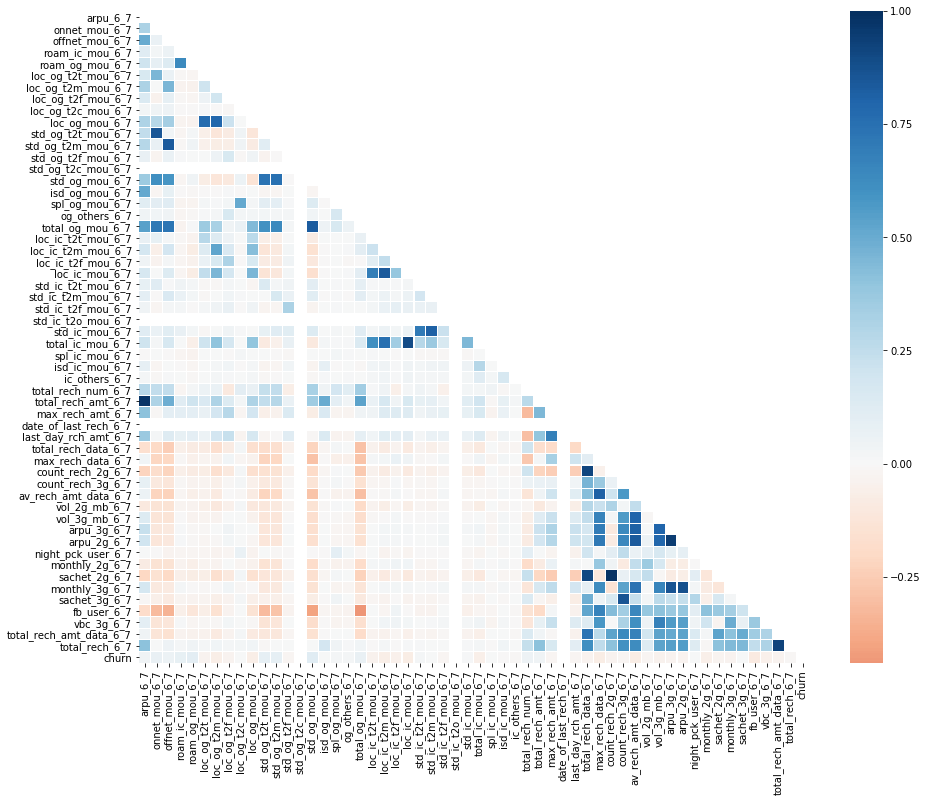

In [724]:
#Correlation of Good Phase Data
col = [c for c in hvCust.columns if c.endswith('_6_7') ] + ['churn']
corrData_6_7 = hvCust[col].corr()
plt.figure(figsize=(15,12))
mask = np.zeros_like(corrData_6_7, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrData_6_7, cmap='RdBu', mask=mask, center=0, linewidths= 0.1)
plt.show()

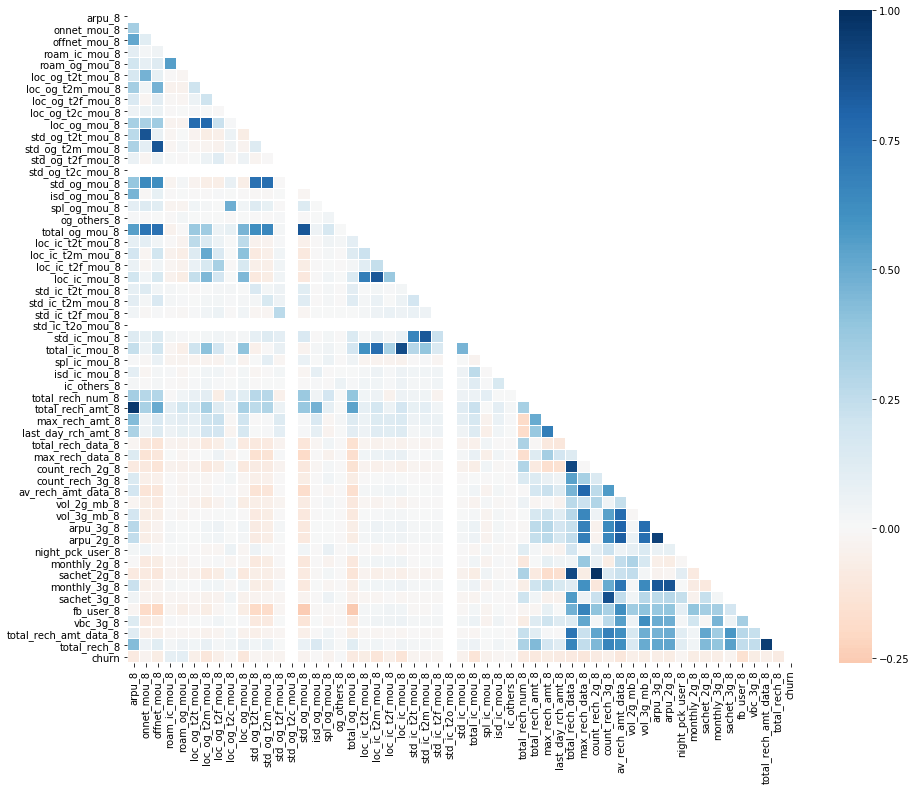

In [725]:
#Correlation of Action Phase Data
col = [c for c in hvCust.columns if c.endswith('_8') ] + ['churn']
corrData_8 = hvCust[col].corr()
plt.figure(figsize=(15,12))
mask = np.zeros_like(corrData_8, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrData_8, cmap='RdBu', mask=mask, center=0, linewidths= 0.1)
plt.show()

Both heatmap shows similar trend, will drop few highly correlated column.

In [726]:
for c in corrData_6_7.columns:
    corrCol = corrData_6_7[(corrData_6_7[c] >= 0.8) & (corrData_6_7[c] < 1)].index
    if (corrCol.size > 0):
        print("'{0}' correlated with '{1}' : {2}".format(c, corrCol[0], corrData_6_7.loc[c, corrCol[0]]))
print()        
print('-----------------------------------------------------------------')
print()
for c in corrData_8.columns:
    corrCol = corrData_8[(corrData_8[c] >= 0.8) & (corrData_8[c] < 1)].index
    if (corrCol.size > 0):
        print("'{0}' correlated with '{1}' : {2}".format(c, corrCol[0], corrData_8.loc[c, corrCol[0]]))

'arpu_6_7' correlated with 'total_rech_amt_6_7' : 0.9807394665291236
'onnet_mou_6_7' correlated with 'std_og_t2t_mou_6_7' : 0.8532342495252453
'offnet_mou_6_7' correlated with 'std_og_t2m_mou_6_7' : 0.8378648579136188
'std_og_t2t_mou_6_7' correlated with 'onnet_mou_6_7' : 0.8532342495252453
'std_og_t2m_mou_6_7' correlated with 'offnet_mou_6_7' : 0.8378648579136188
'std_og_mou_6_7' correlated with 'total_og_mou_6_7' : 0.8306598698014078
'total_og_mou_6_7' correlated with 'std_og_mou_6_7' : 0.8306598698014078
'loc_ic_t2m_mou_6_7' correlated with 'loc_ic_mou_6_7' : 0.8390201505961243
'loc_ic_mou_6_7' correlated with 'loc_ic_t2m_mou_6_7' : 0.8390201505961243
'std_ic_t2m_mou_6_7' correlated with 'std_ic_mou_6_7' : 0.8148677594191372
'std_ic_mou_6_7' correlated with 'std_ic_t2m_mou_6_7' : 0.8148677594191372
'total_ic_mou_6_7' correlated with 'loc_ic_mou_6_7' : 0.8918093650110335
'total_rech_amt_6_7' correlated with 'arpu_6_7' : 0.9807394665291236
'total_rech_data_6_7' correlated with 'count_

In [727]:
#Let's drop highly correlated Columns
colToDrop = ['total_rech_amt_6_7','total_rech_amt_8','std_og_t2t_mou_6_7','std_og_t2t_mou_8','std_og_t2m_mou_6_7','std_og_t2m_mou_8','std_og_mou_6_7','std_og_mou_8','loc_ic_mou_6_7','loc_ic_mou_8','std_ic_t2m_mou_6_7','std_ic_t2m_mou_8','total_rech_data_6_7','total_rech_data_8','sachet_3g_6_7','sachet_3g_8','sachet_2g_6_7','sachet_2g_8']
hvCust.drop(labels=colToDrop, inplace=True, axis=1)

## Visualising Data

In [728]:
hvCust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28163 entries, 7 to 99997
Data columns (total 99 columns):
mobile_number              28163 non-null int64
circle_id                  28163 non-null int64
loc_og_t2o_mou             28163 non-null float64
std_og_t2o_mou             28163 non-null float64
loc_ic_t2o_mou             28163 non-null float64
arpu_8                     28163 non-null float64
onnet_mou_8                28163 non-null float64
offnet_mou_8               28163 non-null float64
roam_ic_mou_8              28163 non-null float64
roam_og_mou_8              28163 non-null float64
loc_og_t2t_mou_8           28163 non-null float64
loc_og_t2m_mou_8           28163 non-null float64
loc_og_t2f_mou_8           28163 non-null float64
loc_og_t2c_mou_8           28163 non-null float64
loc_og_mou_8               28163 non-null float64
std_og_t2f_mou_8           28163 non-null float64
std_og_t2c_mou_8           28163 non-null float64
isd_og_mou_8               28163 non-null flo

In [691]:
hvCust.columns[hvCust.dtypes == 'O']

Index(['date_of_last_rech_8', 'date_of_last_rech_data_8'], dtype='object')

In [693]:
hvCust.isnull().sum()

mobile_number                     0
circle_id                         0
loc_og_t2o_mou                    0
std_og_t2o_mou                    0
loc_ic_t2o_mou                    0
arpu_8                            0
onnet_mou_8                       0
offnet_mou_8                      0
roam_ic_mou_8                     0
roam_og_mou_8                     0
loc_og_t2t_mou_8                  0
loc_og_t2m_mou_8                  0
loc_og_t2f_mou_8                  0
loc_og_t2c_mou_8                  0
loc_og_mou_8                      0
std_og_t2f_mou_8                  0
std_og_t2c_mou_8                  0
isd_og_mou_8                      0
spl_og_mou_8                      0
og_others_8                       0
total_og_mou_8                    0
loc_ic_t2t_mou_8                  0
loc_ic_t2m_mou_8                  0
loc_ic_t2f_mou_8                  0
std_ic_t2t_mou_8                  0
std_ic_t2f_mou_8                  0
std_ic_t2o_mou_8                  0
std_ic_mou_8                